In [5]:
pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in c:\users\kicks\anaconda3\lib\site-packages (0.1.54)Note: you may need to restart the kernel to use updated packages.



In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date
today  = date.today()
startDate = today.replace(today.year-1)
print(startDate)
print(today)

2019-10-06
2020-10-06


In [2]:
[today.replace(today.day+i) for i in range(30)]

[datetime.date(6, 10, 6),
 datetime.date(7, 10, 6),
 datetime.date(8, 10, 6),
 datetime.date(9, 10, 6),
 datetime.date(10, 10, 6),
 datetime.date(11, 10, 6),
 datetime.date(12, 10, 6),
 datetime.date(13, 10, 6),
 datetime.date(14, 10, 6),
 datetime.date(15, 10, 6),
 datetime.date(16, 10, 6),
 datetime.date(17, 10, 6),
 datetime.date(18, 10, 6),
 datetime.date(19, 10, 6),
 datetime.date(20, 10, 6),
 datetime.date(21, 10, 6),
 datetime.date(22, 10, 6),
 datetime.date(23, 10, 6),
 datetime.date(24, 10, 6),
 datetime.date(25, 10, 6),
 datetime.date(26, 10, 6),
 datetime.date(27, 10, 6),
 datetime.date(28, 10, 6),
 datetime.date(29, 10, 6),
 datetime.date(30, 10, 6),
 datetime.date(31, 10, 6),
 datetime.date(32, 10, 6),
 datetime.date(33, 10, 6),
 datetime.date(34, 10, 6),
 datetime.date(35, 10, 6)]

In [6]:
RISKY_ASSET = 'MSFT'
df = yf.download(RISKY_ASSET, start=today.replace(today.year-1),
 end=date.today(), adjusted=True)
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


210.3800048828125

[*********************100%***********************]  1 of 1 completed
Average return: 0.24%


98.86021423339844

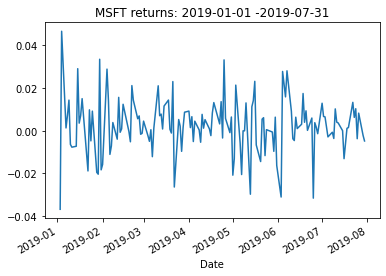

In [21]:
RISKY_ASSET = 'MSFT'
START_DATE = '2019-01-01'
END_DATE = '2019-07-31'
df = yf.download(RISKY_ASSET, start=START_DATE,
 end=END_DATE, adjusted=True)
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()
print(f'Average return: {100 * returns.mean():.2f}%')
returns.plot(title=f'{RISKY_ASSET} returns: {START_DATE} -{END_DATE}')
adj_close[0]

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date
from scipy.stats import norm
class MC_GBM_European(object):
    
    def __init__(self):
        # Basic data
        self._ticker = None
        self._end_date = date.today()
        self._start_date = self._end_date.replace(self._end_date.year-1)
        
        # returns 
        self._return = None
        self._adj_close = None
        
        # for GBM and black scholes
        self._So = None
        self._n_sims = None
        self._mu = None
        self._sigma = None
        self._T = None # time to expiration
        self._N = None
        self._gbmpath = None
        self._K = None
        self._r = None
        self._BS_prem = None
        self._MC_BS_prem = None
        
    def set_ticker(self,TICKER):
        self._ticker = TICKER
        
    def set_return(self):
        df = yf.download(self._ticker, start=self._start_date,end=self._end_date, adjusted=True)
        self._adj_close = df['Adj Close']
        self._return = self._adj_close.pct_change().dropna() # log return

    def get_return(self):
        return self._return
    
    def plot_return(self):
        print(f'Average return: {100 * self._return.mean():.2f}%')
        self._return.plot(title=f'{self._ticker} Price until expiration: {self._start_date} - {self._end_date}')
    
    def set_gbm_n_expiration(self,T): # T = time until expiration
        self._So = self._adj_close[-1]
        self._n_sims = 100
        self._mu = self._return.mean()
        self._sigma = self._return.std()
        self._T = T
        self._N = T
        
        
        dt = self._T /self._N
        dW = np.random.normal(scale = np.sqrt(dt),size=(self._n_sims, self._N))
        W = np.cumsum(dW, axis=1)
        time_step = np.linspace(dt, self._T, self._N)
        time_steps = np.broadcast_to(time_step, (self._n_sims, self._N))
        self._gbmpath = self._So * np.exp((self._mu - 0.5 *self._sigma ** 2) * time_steps+ self._sigma * W)
        self._gbmpath  = np.insert(self._gbmpath, 0, self._So, axis=1)
    
    def get_gbm(self):
        return self._gbmpath
    
    def plot_gbm(self):
        PLOT_TITLE = (f'{self._ticker} Simulation 'f'({self._start_date}:{self._end_date})')
        index  = [self._end_date.replace(self._end_date.day+i) for i in range(self._T+1)]
        gbm_simulations_df = pd.DataFrame(np.transpose(self._gbmpath),index=index)
        # plotting
        ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
        line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1),color='red')
        ax.set_title(PLOT_TITLE, fontsize=16)
        
    def set_strike_n_interest(self,strike,interest_rate):
        self._K = strike
        self._r = interest_rate
    # we have S0,K,r,sigma,T, we can compute bs
    def get_BS( self, type='call'):
        d1 = (np.log(self._So/self._K) + (self._r + 0.5 * self._sigma**2) * self._T)/(self._sigma * np.sqrt(self._T))
        d2 = (np.log(self._So/self._K) + (self._r - 0.5 * self._sigma**2) * self._T)/(self._sigma * np.sqrt(self._T))
        if type == 'call':
            val = (self._So*norm.cdf(d1, 0, 1)-self._K*np.exp(-self._r*self._T)*norm.cdf(d2, 0, 1))
        elif type == 'put':
            val = (self._K*np.exp(-self._r*self._T)*norm.cdf(-d2, 0, 1)-self._So *norm.cdf(-d1, 0, 1))
        self._BS_prem = val
        return self._BS_prem
    
    def get_MC_BS(self):
        discount_factor = np.exp(-1 * self._r * self._T)
        self._MC_BS_prem = discount_factor * np.average(np.maximum(0,self._gbmpath[:, -1] - self._K))
        return self._MC_BS_prem
 


In [ ]:
#When i simulate i get mu and sigma from mean and std of log return 1 year
# I use this to simulate GBM and then Monte carlo price
# Can i use the same sigma for Analytical BS?

In [8]:
msft = MC_GBM_European()
msft.set_ticker('MSFT')
msft.set_return()
msft.set_gbm_n_expiration(21)
msft.set_strike_n_interest(150,0.002)
print(msft.get_BS())
print(msft.get_MC_BS())
# This is analytical BS price

[*********************100%***********************]  1 of 1 completed
66.55551853344227
65.53331806187661


In [ ]:
msft.plot_return()

In [7]:
msft.plot_gbm()

NameError: name 'msft' is not defined

In [5]:
def get_option_prem(ticker,time,strike,interest):
    msft = MC_GBM_European()
    msft.set_ticker(ticker)
    msft.set_return()
    msft.set_gbm_n_expiration(time)
    msft.set_strike_n_interest(strike,interest)
    print(msft.get_BS())
    print(msft.get_MC_BS())

In [6]:
import euroOptions
get_option_prem('MSFT',21,210, 0.001)

[*********************100%***********************]  1 of 1 completed
10.401867946292612
11.579376386671047


In [66]:
for i in np.arange(150,245.5,step = 2.5):
    print("Strike: " + str(i))
    get_option_prem('MSFT',21,i, 0.0014)

Strike: 150.0
[*********************100%***********************]  1 of 1 completed
60.5510464014599
63.535387909118796
Strike: 152.5
[*********************100%***********************]  1 of 1 completed
58.13220288943691
58.72931182858942
Strike: 155.0
[*********************100%***********************]  1 of 1 completed
55.71751668095422
58.853415882179895
Strike: 157.5
[*********************100%***********************]  1 of 1 completed
53.308554754790975
57.25226245463234
Strike: 160.0
[*********************100%***********************]  1 of 1 completed
50.90730332506837
56.00214912037569
Strike: 162.5
[*********************100%***********************]  1 of 1 completed
48.51622158779037
54.995767560397724
Strike: 165.0
[*********************100%***********************]  1 of 1 completed
46.13828565798269
48.13999427520235
Strike: 167.5
[*********************100%***********************]  1 of 1 completed
43.77701796142196
41.210007902817395
Strike: 170.0
[*********************100%****